### Bank Transaction Categorization Using Random Forest Algorithm
##### By Muhammad Amsyar Luqman Bin Md Hanif
#### 1. Introduction
##### MoneyLion serves as a platform that assists users by creating personalized financial solutions for their users. Given that thousands of transactions happen daily, categorizing transactions is essential so that MoneyLion can group the transaction by category to discover insights and advise users on how to manage their financial better. This report presents the implementation of a Random-Forest Classification model t0 categorize the transactions using textual information, numerical features, and user profile data. This model integrates TF-IDF Vectorization, One-Hot Encoding, and Cross Validation to ensure robustness.

#### 2. Problem Definition and Algorithm
##### 2.1 Task Definition
##### The problem addressed in this report is the automated categorizing of banking transactions. This is based on descriptions, amunts, and user profile attributes. As Artificial Intelligence continue to evolve in helpful manner, manual categorization is inefficient and prone to error. This problem is interesting because:
##### 1) Automated transaction classification helps users to better track their financial well-being
##### 2) Fraud detection is much easier if any unusual transaction appears.
##### 3) Manual categorization is infeasible at large scale as human error are more likely to happen
##### 2.2 Algorithm Definition
##### To address this automation problem, Random Forest Algorithm is suitable to classify the transactions. Random Forest Classification is a powerful machine learning algorithm that incoporates multiple decison trees to classify data.

#### 3. Data and Preprocessing
##### The dataset contains two files:
##### `bank_transaction.csv` contains the transactions data and expected categories
##### `user_profile.csv` contains selected of users and their financial profiles

In [1]:
# IMPORT STATEMENTS
import pandas as pd
import re
import warnings
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# LOAD DATASET

bank_transaction = pd.read_csv("bank_transaction.csv")
user_profile = pd.read_csv("user_profile.csv")

In [3]:
# PREVIEW THE BANK TRANSACTION DATASET
bank_transaction.head()

,client_id,bank_id,account_id,txn_id,txn_date,description,amount,category
0,1,1,1,4,2023-09-29 00:00:00,Earnin PAYMENT Donat...,20.0,Loans
1,1,1,1,3,2023-08-14 00:00:00,ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...,25.0,Transfer Credit
2,1,1,1,5,2023-09-25 00:00:00,MONEY TRANSFER AUTHOR...,20.0,Loans
3,1,1,2,1,2023-06-02 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,16.0,Transfer Credit
4,1,1,2,2,2023-06-01 00:00:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,4.0,Transfer Credit


##### The distribution of the Category in the `bank_transaction` dataset is presented below with `Uncategorized` category having the most occurences in the dataset. 

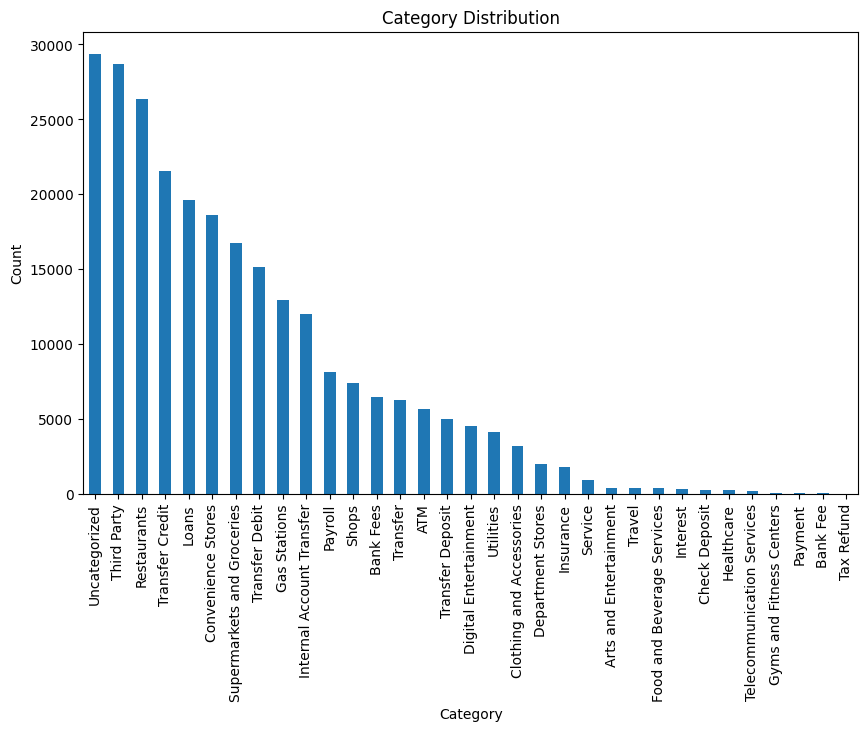

In [4]:
# CATEGORY DISTRIBUTION

plt.figure(figsize=(10, 6))
bank_transaction['category'].value_counts().plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [5]:
# PREVIEW THE USER PROFILE DATASET
user_profile.head()

,CLIENT_ID,IS_INTERESTED_INVESTMENT,IS_INTERESTED_BUILD_CREDIT,IS_INTERESTED_INCREASE_INCOME,IS_INTERESTED_PAY_OFF_DEBT,IS_INTERESTED_MANAGE_SPENDING,IS_INTERESTED_GROW_SAVINGS
0,1,False,False,False,False,False,False
1,2,False,False,False,False,False,False
2,3,False,False,False,False,False,False
3,4,False,True,True,True,True,True
4,5,True,False,True,True,True,False


##### The distribution of the User Profile in the `user_profile` dataset is presented below with each feature profile is almost identically distributed. This indicates that there a re quite a variety of combination between user profiles.

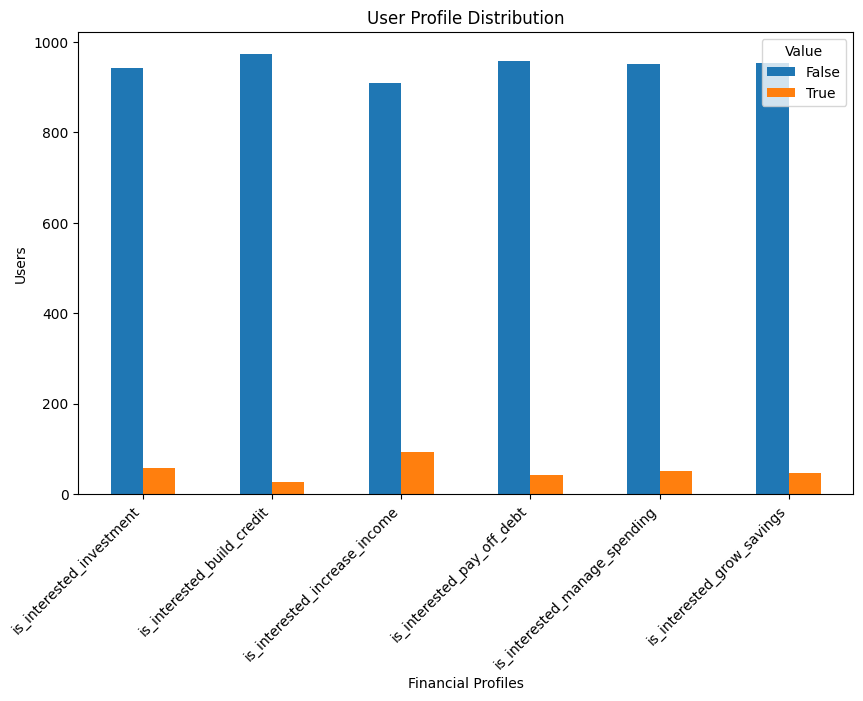

In [6]:
# USER PROFILE DISTRIBUTION

bool_cols = ['is_interested_investment', 'is_interested_build_credit', 'is_interested_increase_income', 'is_interested_pay_off_debt', 'is_interested_manage_spending', 'is_interested_grow_savings']

user_profile.columns = user_profile.columns.str.lower()
bool_counts = user_profile[bool_cols].apply(lambda col: col.value_counts())

fig, ax = plt.subplots(figsize=(10, 6))
bool_counts.T.plot(kind="bar", stacked=False, ax=ax)

ax.set_title("User Profile Distribution")
ax.set_ylabel("Users")
ax.set_xlabel("Financial Profiles")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Value", labels=["False", "True"])
plt.show()

#### 3.1 Text Cleaning
##### The preprocessing begins with extracting the `description` column in `bank_transaction.csv` and converting the payment reference text to lowercase and remove digits and common stopwords in English. Ths is necessary for the TF-IDF Vectorization later so that we can find the keywords of the transaction to predict the category.

In [7]:
# EXTRACTING KEYWORDS FROM DESCRIPTION COLUMN

stopwords_list = set([
    "the", "is", "in", "it", "of", "for", "on", "with", "to", "from", "by", "at", 
    "a", "an", "and", "or", "this", "that", "be", "was", "were", "has", "had", 
    "have", "as", "but", "if", "then", "so", "because", "about", "into", "out", 
    "over", "under", "between", "after", "before", "above", "below", "again", 
    "once", "during", "while", "can", "will", "just", "don", "should", "now"
])

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = text.strip()
        text = " ".join([word for word in text.split() if word not in stopwords_list])
        return text
    return ""

bank_transaction["cleaned_description"] = bank_transaction["description"].apply(clean_text)

#### 3.2 One-Hot Encoding
##### In the `user_profile` dataset, converting the boolean columns to integer representations allows for better and more convenient predictors for categorization in the form of numerical value. TRUE is represented by 1's and FALSE is represented by 0's

In [8]:
# TRANSFORM THE USER PROFILE DATASET TO ONE HOT ENCODING

user_profile.columns = user_profile.columns.str.lower()
bool_cols = user_profile.select_dtypes(include=['bool']).columns
encoder = OneHotEncoder(drop='if_binary', dtype=int)
encoded_array = encoder.fit_transform(user_profile[bool_cols]).toarray()
encoded_df = pd.DataFrame(encoded_array, columns=bool_cols)
user_profile[bool_cols] = encoded_df
user_profile.head()

,client_id,is_interested_investment,is_interested_build_credit,is_interested_increase_income,is_interested_pay_off_debt,is_interested_manage_spending,is_interested_grow_savings
0,1,0,0,0,0,0,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,1,1,1,1,1
4,5,1,0,1,1,1,0


#### 3.3 Combining The Datasets
##### Merging both datasets on `client_id` to get more significant predictors into the model and make better predictions 

In [9]:
# MERGE THE BANK TRANSACTION AND USER PROFILE DATASETS

bank_transaction["txn_date"] = pd.to_datetime(bank_transaction["txn_date"])
combined = pd.merge(bank_transaction, user_profile, on="client_id", how="left")
combined = combined.dropna(subset=["category"])
combined["category"] = combined["category"].astype("category").cat.codes

#### 4. Model and Training
##### The primary model being Random Forest Classifier, integrated with Pipelines to better re-assess the data. The model is trained using cross-validation to ensure stabilty among splits.
##### Random Forest Classifier has the ability to handle mixed data types, transforming them into a powerful and robust model. This algorihtm handles categorical and continuous data accordingly, and able to efficiently handle large amount of transaction data embedded in the datasets. Random Forest Classification uses multiple decision tress to genralize predictions instead od overfitting the model with numerous predictors. 
#### 4.1 Feature Selection
##### The model is focusing on the transaction amount, transaction date, payment description (decomposed into keywords not including common stopwords), and users financial profiles to estimate which categories the transaction fall into.

In [10]:
# FEATURE SELCTION

features = ["cleaned_description", "txn_date", "amount"] + list(bool_cols)
xcols = combined[features]
ycol = combined["category"]

#### 4.2 Train Test Split
##### The model split the dataset into train dataset and test dataset. This is to ensure that the model is better of capturing the predictors rather than memoizing. The model allocate 75% of the data to be trained and the remaining 25% for testing purposes

In [11]:
# TRAIN TEST SPLIT

x_train, x_test, y_train, y_test = train_test_split(xcols, ycol, test_size=0.25, random_state=42, stratify=ycol)

#### 4.3 Pipeline
##### Although Random Forest is the main algorithm that classifies the transactions, Pipeline is also needed to handle text entries (payment description) and variety of transaction amounts. TF-IDF Vectorizer has a crucial role in determining the features that appear often in the `description`. StandardScaler normalize the transaction amount. The model has an integrated Pipeline and Random Forest Classifier with 50 decision trees.

In [12]:
# PIPELINE CREATION

pipeline = ColumnTransformer([
    ("tfidf", TfidfVectorizer(max_features=100), "cleaned_description"),
    ("amount", StandardScaler(), ["amount"]),
], remainder="drop")

model = Pipeline([
        ("pipeline", pipeline),
        ("classifier", RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1))
])

#### 4.4 Training The Model
##### The dataset is trained into the model built earlier. Cross validation scores are needed as benchmark for future model re-development. The model is being fitted for an average of 3 minutes since it has about 200000 rows to be loaded.

In [13]:
# TRAIN THE MODEL

pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore')
model.fit(x_train, y_train)
cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')

#### 5. Experimental Results
#### 5.1 Testing The Model
##### The Model was evaluated using Cross Validation, with accuracy and classification report being the main indicator to determine model's performance. The model had achieved ~78% accuracy categorizing the transactions.

In [14]:
# TEST THE MODEL

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Model Accuracy {accuracy}")
print(f"Classfication report\n{classification_rep}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

Model Accuracy 0.7795485138710526
Classfication report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1418
           1       0.62      0.64      0.63        99
           2       0.75      0.33      0.46         9
           3       0.95      0.96      0.96      1608
           4       0.98      0.96      0.97        53
           5       0.44      0.38      0.41       797
           6       0.65      0.69      0.67      4658
           7       0.31      0.27      0.29       500
           8       0.62      0.67      0.65      1131
           9       0.37      0.24      0.29        86
          10       0.59      0.64      0.62      3230
          11       1.00      0.41      0.58        17
          12       0.45      0.33      0.38        52
          13       0.64      0.57      0.60       438
          14       0.57      0.84      0.68        70
          15       0.94      0.91      0.93      2996
          16       0.90   

#### 5.2 Additional K-Fold Cross-Validation
##### The model was re-evaluated again using 5-Fold Cross-Validation. On all folds the model again performed well, having accuracy between [77, 79] percent. This indicates that the model accuracy could be between the range of [77, 79] percent.

In [15]:
# K-FOLD CROSS VALIDATION

folds = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(folds.split(xcols), 1):
    print(f"Fold {fold}: Train Size = {len(train_index)}, Test Size = {len(test_index)}")

    x_train, x_test = xcols.iloc[train_index], xcols.iloc[test_index]
    y_train, y_test = ycol.iloc[train_index], ycol.iloc[test_index]

    pipeline = ColumnTransformer([
    ("tfidf", TfidfVectorizer(max_features=100), "cleaned_description"),
    ("amount", StandardScaler(), ["amount"]),
], remainder="drop")

    model = Pipeline([
        ("pipeline", pipeline),
        ("classifier", RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1))
])

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Fold {fold}: Accuracy = {accuracy}")

Fold 1: Train Size = 206817, Test Size = 51705
Fold 1: Accuracy = 0.7786094188182962
Fold 2: Train Size = 206817, Test Size = 51705
Fold 2: Accuracy = 0.7783773329465236
Fold 3: Train Size = 206818, Test Size = 51704
Fold 3: Accuracy = 0.7779282067151477
Fold 4: Train Size = 206818, Test Size = 51704
Fold 4: Accuracy = 0.7824346278817886
Fold 5: Train Size = 206818, Test Size = 51704
Fold 5: Accuracy = 0.7781989788024137


#### 6. Future Work
##### The model had the capability of correctly predicting ~78% transaction categories. This can always be enhanced to achieve more than 90% accuracy. To further enhance the transaction labeling algorithm, improvements should focus on refining data preprocessing, integrating more advanced and complex models, as well as including other real-world deployment strategies.
##### 6.1 Future Development in The Next 1 Month
##### The development should focus on feature engineering capabilities such as implementing word embeddings for better semantic understanding of `description` and extract seasonal trends from `txn_date`. The development should also focus on handling the class imbalance and not just classifying Uncategorized transactions easily.
##### 6.1 Future Development in The Next 3 Months
##### Once we have the baseline and the basic model fully optimized, the development can focus on creating Neural Network and Deep Learning Models to incorporate more decision making in classifying the transactions. For instance, exploring some other classification models such as XGBoost or Recurrent Neural Network to better estimate the categories. Another method that might be interesting is transaction description memoization. This could be an interesting factor as it eliminates redundancy to check every transaction given we already have a precedence in the dataset.

#### 7. Conclusion
##### This report entails the model bulding to predict the transaction category. This model focuses on Random Forest Classifier, together with the Pipeline and the Data Preprocessing. As the model explained and achieved, text manipulation and numerical predictors play a major role in determining the categories. The model, on average classify ~78% transactions correctly, providing an indicator on the reliability of the model. 

In [16]:
import nbformat
from nbconvert import HTMLExporter
with open("analysis.ipynb") as f:
    notebook = nbformat.read(f, as_version=4)
html_exporter = HTMLExporter()
body, _ = html_exporter.from_notebook_node(notebook)
with open("bank_transaction_categorization_model.html", "w", encoding="utf-8") as f:
    f.write(body)